## Content-based image retrieval by autoencoders

**Content-based image retrieval** (CBIR) is the mechanism of retrieving images relevant to a given query from a large collection of images known as an image database, based on their semantic or visual content rather than on derived attributes or keyword descriptors prescriptively defined for them.

As shown in the picture there are some basic steps involved in query and retrieval:

- Feature extraction: Of course, this part involves the extraction of image characteristics, such as texture, color, etc. It could also be considered a preprocessing step to, for example, resize or improve the quality of the images.
- Similarity measure: The similarity measurement is used to estimate the query image with the database images by similarity. The dissimilarity between the feature vector of the query image and the database images is calculated using different distance metrics. The higher the dissimilarity, the less similar the two images are. Some commonly used distances are: Euclidean distance, block distance, Minkowski distance and Mahalanobis distance.
- Retrieve the results: The N most similar images are displayed to the user.

![CBIR](../images/cbir_01.jpg)


This notebook is based on the work published by Rupapara et al.[<sup>1</sup>](#fn1). In here special neural network called autoencoder is used for extracting the image features.

#### Loading libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

#### Loading dataset

In [2]:
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Images come as vectors, so it is necessary to reshape them.
x_train = np.reshape(x_train, (len(x_train), input_shape[0], 
                               input_shape[1], input_shape[2]))
x_test = np.reshape(x_test, (len(x_test), input_shape[0], 
                             input_shape[1], input_shape[2]))

### Feature extraction phase: autoencoder

An autoencoder is a neural network that is unsupervised which means that doesn't require any labeled data. 

They work by compressing the input into a latent space representation and reconstructing the output from this representation:

- Encoder: the part of the network that compresses the input into a latent space  representation (i.e., representation of compressed data). It can be represented by an encoding function \\( h=f(x) \\).
- Decoder: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function \\( r=g(h) \\).

![CBIR Autoencoder](../images/cbir_02.jpg)

In [3]:
# Definition of the autoencoder network

def autoencoder_model(input_shape=(28, 28, 1)):
    """ Autoencoder model """
    input_img = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

autoencoder = autoencoder_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0     

#### Autoencoder for denoising

Instead of training the autoencoder to learn an original image and reconstruct it, let's train it, so it can denoise an image. To do this, we modify the input adding some noise will maintain the original image as target.

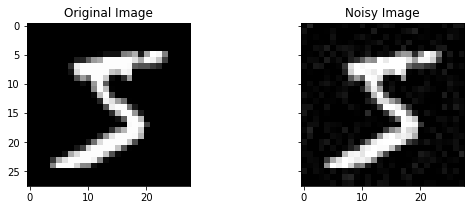

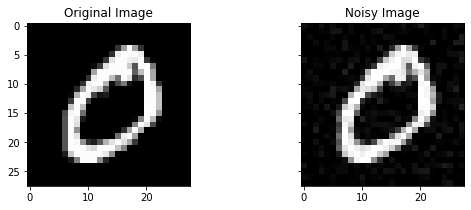

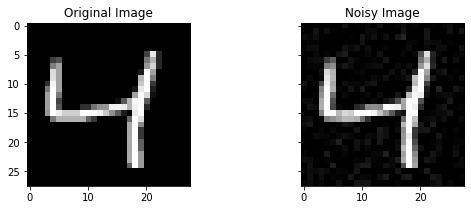

In [4]:
# Adding noise to images

noise_factor = 0.05

x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

for idx in range(3):
    y = autoencoder.predict(np.expand_dims(x_train_noisy[idx, ...], axis=0))
    fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_train[idx, ...]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_train_noisy[idx, ...]), cmap='gray')
    ax[1].set_title('Noisy Image')
    plt.show()

#### Training the autoencoder for 10 epochs.

It takes about 15 minutes in CPU, only because it is a smal network an

In [5]:
tf.random.set_seed(5)

model_name = 'autoencoder_mnist.h5'

if not os.path.exists(model_name):
    autoencoder = autoencoder_model()
    autoencoder.fit(x_train, x_train_noisy,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(x_test, x_test_noisy))

    autoencoder.save(model_name)
else:
    autoencoder = load_model(model_name)

#### Plot of the result of the denoising

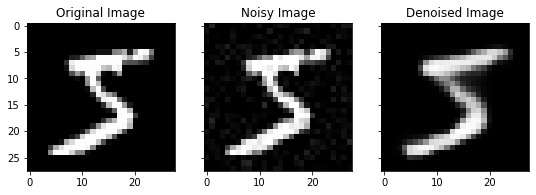

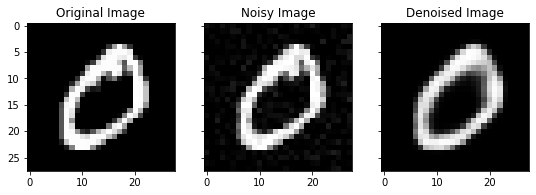

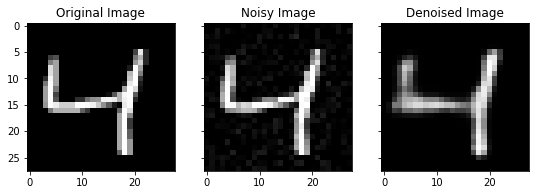

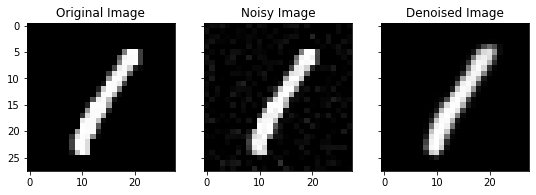

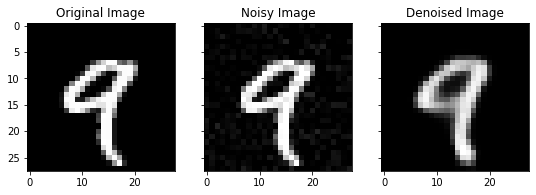

In [6]:
for idx in range(5):
    y = autoencoder.predict(np.expand_dims(x_train_noisy[idx, ...], axis=0))
    
    fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_train[idx, ...]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_train_noisy[idx, ...]), cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[2].imshow(np.squeeze(y), cmap='gray')
    ax[2].set_title('Denoised Image')
    plt.show()

#### Using the autoencoder for feature extraction (latent space features)

In [7]:
# Obtain features from middle layer
autoencoder = load_model(model_name)
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer('encoder').output)

### Creation of the database 

Creation of the database by extracting the autoencoder features for all images in the training set.

In [8]:
# Extracting features from train data
codes_name = 'learned_codes_mnist.npy'

if not os.path.exists(codes_name):
    learned_codes = encoder.predict(x_train)
    # The sise of the latent space is (None, 4, 4, 8), 
    # so we have to vectorize it.
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * 
                                          learned_codes.shape[2] * 
                                          learned_codes.shape[3])
    np.save(codes_name, learned_codes)
else:
    learned_codes = np.load(codes_name)

### Retrieval phase

We retrieve the most similar images from 9 test images.

In [9]:
def euclidean_distance(x ,y):
    return np.sqrt(np.sum(np.square(x - y)))

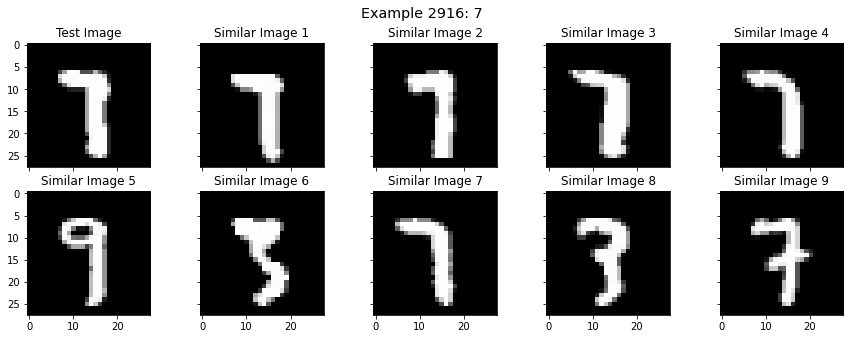

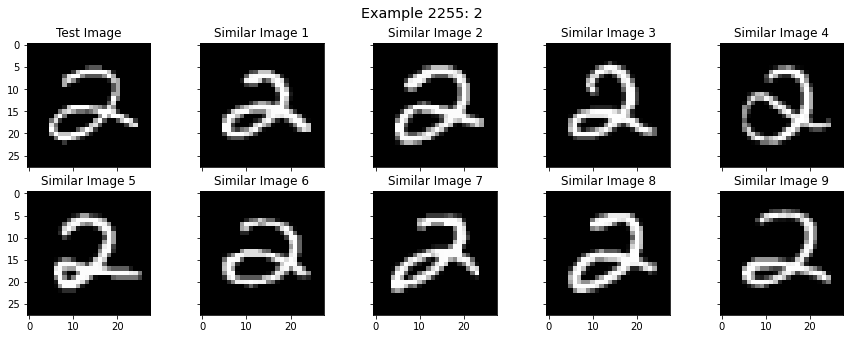

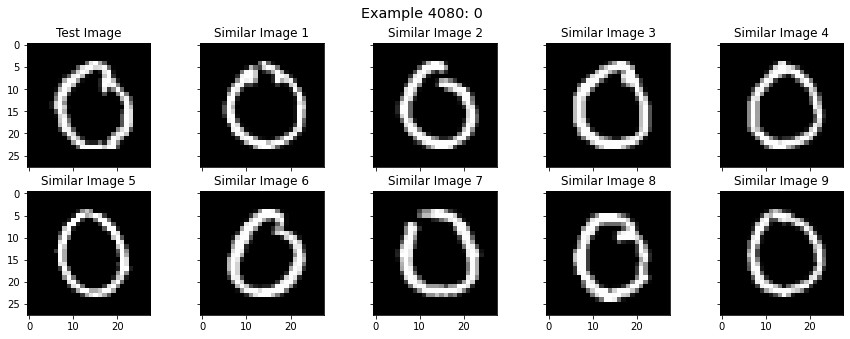

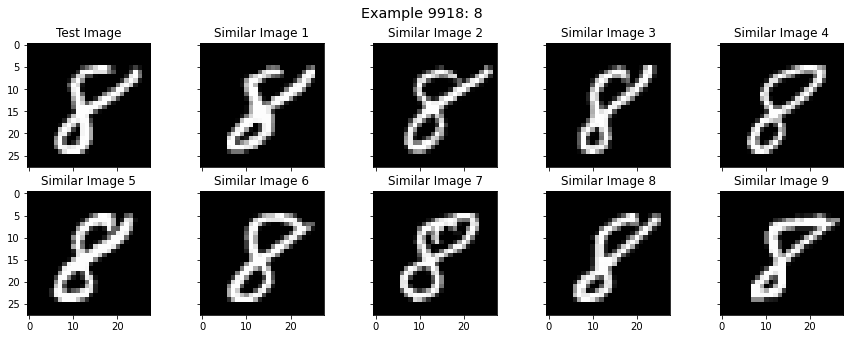

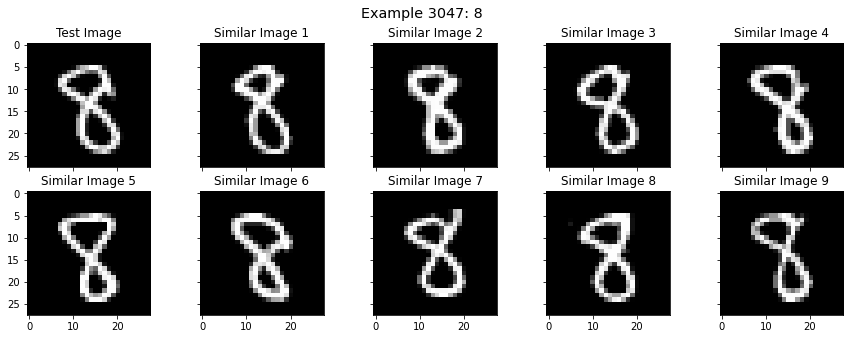

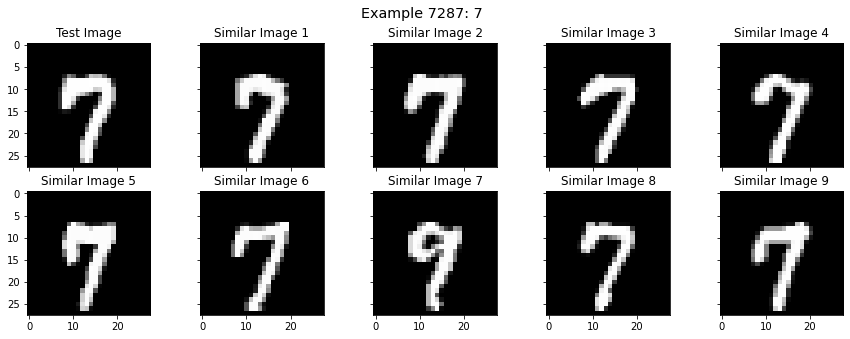

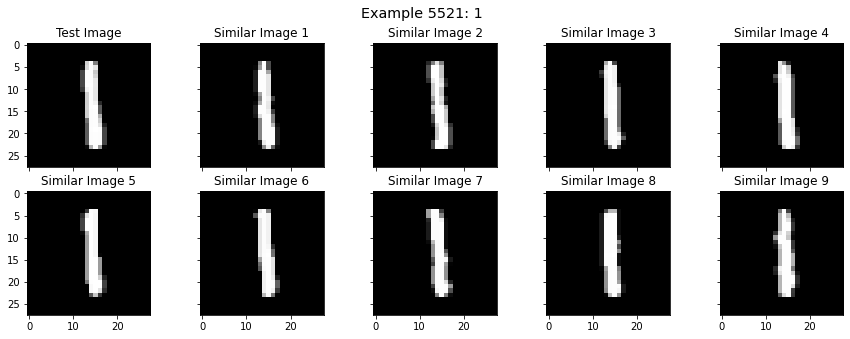

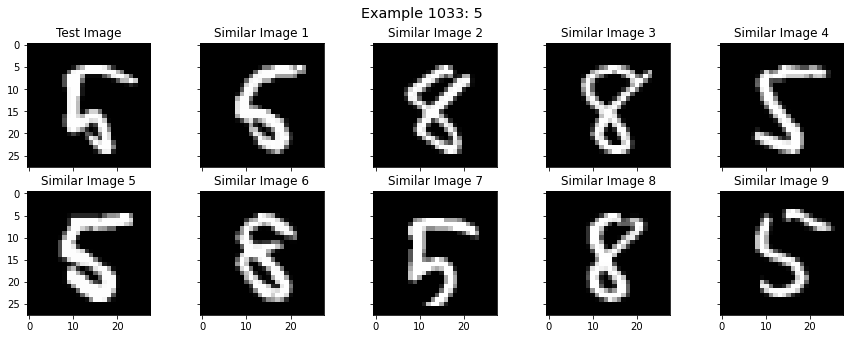

In [10]:
num_retrieve_images = 9
np.random.seed(5)
    
indexes = np.random.randint(0, x_test.shape[0], 8) # Select 8 random images for testing

for idx in indexes:
    # Extract features from test image
    im_test = x_test[idx]
    test_code = encoder.predict(np.expand_dims(im_test, axis=0))
    test_code = test_code.reshape(test_code.shape[0], test_code.shape[1] * 
                                  test_code.shape[2] * test_code.shape[3])
    test_code = np.squeeze(test_code)
    
    # Calculate the distance from
    distances = []
    for code in learned_codes:
        distance = euclidean_distance(code, test_code) # Euclidean norm
        distances.append(distance)
    distances = np.array(distances)
    
    # Ordering the images according to similarity
    sorted_idx = distances.argsort()
    images_idx = sorted_idx[:num_retrieve_images]
    
    
    # Showing the results
    fig, axes = plt.subplots(int((num_retrieve_images + 1)/5 + 0.5), 5,
                           figsize=(15, 5), sharex='col', sharey='row')
    
    fig.suptitle('Example {}: {}'.format(idx + 1, y_test[idx]), fontsize='x-large')
    for ax_idx, ax in enumerate(axes.flat):
        if ax_idx == 0:
            ax.imshow(np.squeeze(im_test), cmap='gray')
            ax.set_title('Test Image')
        else:
            ax.imshow(np.squeeze(x_train[images_idx[ax_idx - 1]]), cmap='gray')
            ax.set_title('Similar Image {}'.format(ax_idx))
            
    plt.show()

    

### References

1. <span id="fn1">Rupapara, Vaibhav, et al. "Auto-Encoders for Content-based Image Retrieval with its Implementation Using Handwritten Dataset." 2020 5th International Conference on Communication and Electronics Systems (ICCES). IEEE, 2020.</span>